# Model

In [9]:
import librosa as lb
from matplotlib import pyplot as plt
import numpy as np
import os
from librosa import display

In [2]:
from sklearn.decomposition import NMF

## Generate sample dataset

In [10]:
train = []

for i in range(70):
    #r = np.random.randint(100, 200)
    r = 1000
    train.append(np.random.rand(3,r))
    
xtrain = train[:50]
xtest = train[50:]

xtrain = np.array(xtrain)
xtest = np.array(xtest)
ytrain = xtrain
ytest = xtest

xtrain.shape, ytrain.shape

((50, 3, 1000), (50, 3, 1000))

# Model

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [304]:
batch_size = 16
epochs = 1000
inp = Input(shape =(3, 1000, 1))
out_dim = inp

In [305]:
print('Input:', inp.shape)

H = Conv2D(1, 3, activation='relu', kernel_regularizer='l1')(inp)
H = BatchNormalization()(H)

print('Layer 1:', H.shape)

X_ = Conv2DTranspose(1, 3, activation='relu')(H)
X_ = BatchNormalization()(X_)

print('Layer 2:', X_.shape)

Input: (None, 3, 1000, 1)
Layer 1: (None, 1, 998, 1)
Layer 2: (None, 3, 1000, 1)


In [306]:
class JointLoss(tf.keras.losses.Loss):
    
    def __init__(self):
        super().__init__()
        
    def call(self, y_true, y_pred):
        
        y_pred = tf.squeeze(y_pred, axis=3)
        
        y_pred = tf.math.abs(y_pred) #Check this
        
        t0 = tf.math.divide(y_true, y_pred)
        #t1 = tf.math.log(t0 + 1 - tf.reduce_min(t0).numpy()) #check this
        t1 = tf.math.log(t0)
        t2 = tf.math.multiply(y_true, t1)
        t3 = tf.math.subtract(t2, y_true)
        t4 = tf.math.add(t3, y_pred)
        #print(t4)
        #D = tf.reduce_sum(t4).numpy()
        loss1 = tf.reduce_sum(t4)
        #print(tf.reduce_sum(t4).numpy())
        
        loss2 = tf.reduce_mean(tf.square(y_pred-y_true))
        #print(tf.reduce_mean(tf.square(y_pred-y_true)).numpy())
        #print(loss1+loss2)
        
        return loss1+loss2
        #return D
        #mse = tf.reduce_mean(tf.square(y_pred-y_true))
        #rmse = tf.math.sqrt(mse)
        #return rmse / tf.reduce_mean(tf.square(y_true)) - 1

In [307]:
NMF = Model(inp, X_)
#NMF.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
NMF.compile(optimizer="adam", loss=JointLoss(), run_eagerly=True)

In [308]:
NMF_train = NMF.fit(
    x=xtrain,
    y=ytrain,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True, verbose=1)

Epoch 1/1000
4/4 [==============================] - 0s 11ms/step - loss: 14580.6279
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 14518.0527
Epoch 3/1000
4/4 [==============================] - 0s 10ms/step - loss: 14471.6250
Epoch 4/1000
4/4 [==============================] - 0s 10ms/step - loss: 14418.2275
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 14380.7490
Epoch 6/1000
4/4 [==============================] - 0s 10ms/step - loss: 14339.3848
Epoch 7/1000
4/4 [==============================] - 0s 10ms/step - loss: 14293.7666
Epoch 8/1000
4/4 [==============================] - 0s 9ms/step - loss: 14253.2822
Epoch 9/1000
4/4 [==============================] - 0s 9ms/step - loss: 14213.8438
Epoch 10/1000
4/4 [==============================] - 0s 9ms/step - loss: 14200.0938
Epoch 11/1000
4/4 [==============================] - 0s 10ms/step - loss: 14147.3828
Epoch 12/1000
4/4 [==============================] - 0s 10ms/step - loss: 14112

In [309]:
loss = NMF.evaluate(xtest,  ytest, verbose=1)
print("Test Loss: {}".format(loss))

1/1 [==============================] - 0s 23ms/step - loss: 13354.6436
Test Loss: 13354.6435546875


In [310]:
predictions = NMF.predict(xtest, verbose=1)
predictions = np.squeeze(predictions, axis=3)

1/1 [==============================] - 0s 23ms/step


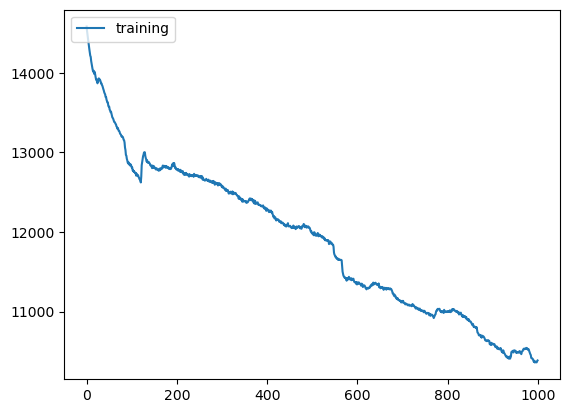

In [311]:
plt.plot(NMF_train.history['loss'])
plt.legend(['training'], loc = 'upper left')
plt.show()

In [312]:
predictions[0]

array([[-0.3799636 , -0.47590497,  0.62462866, ..., -0.10583239,
        -0.47590497,  0.53251666],
       [-0.18415877, -0.47590497,  0.5434172 , ..., -0.03955147,
        -0.47590497,  0.34397706],
       [-0.21072248,  0.645624  , -0.47590497, ..., -0.45886707,
         0.8170638 , -0.47590497]], dtype=float32)

In [313]:
xtest[0]

array([[0.74527681, 0.11640792, 0.4104885 , ..., 0.39683292, 0.58734756,
        0.22629588],
       [0.74192277, 0.46840285, 0.80574836, ..., 0.39740365, 0.01026204,
        0.65862042],
       [0.22602864, 0.49583434, 0.11705063, ..., 0.5024491 , 0.71415062,
        0.04443159]])